In [1]:
! python --version

Python 3.10.2


# Image Classifiacation using CNNs and ResNets in Pytorch

In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [3]:
# Download the dataset
if not os.path.exists('./archive/cifar10.tgz'):
    dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
    download_url(dataset_url, './archive')

In [4]:
# Extract from archive
if not os.path.exists('./data'):
    with tarfile.open('./archive/cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='./data')

In [5]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print(f'No. of traning examples for airplane: {len(airplane_files)}')
print(airplane_files[:5])

No. of traning examples for airplane: 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [7]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print(f'No. of test examples for ship: {len(ship_test_files)}')
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [8]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [9]:
dataset = ImageFolder(data_dir + '/train', transform=ToTensor())

In [10]:
img, label = dataset[0]
print(img.shape, label) # channel, height and width
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [11]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print(f'Label: {dataset.classes[label]} ({label})')
    plt.imshow(img.permute(1, 2, 0)) # channel at the end

Label: airplane (0)


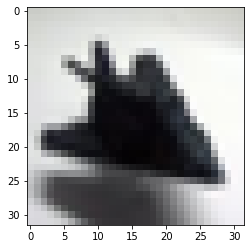

In [21]:
show_example(*dataset[0])

Label: airplane (0)


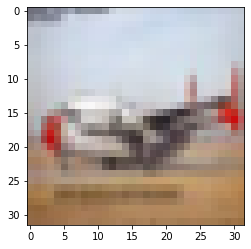

In [22]:
show_example(*dataset[1099])

In [23]:
import numpy as np

def split_indices(n, val_pct=0.1, seed = 99):
    # Determine the size of validation set
    n_val = int(val_pct * n)
    # Set the random seed (for reproducibitiy)
    np.random.seed(seed)
    # create random premutation of 0 to n - 1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [24]:
val_pct = 0.2
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_pct, rand_seed)
print(f'({len(train_indices)}, {len(val_indices)})')
print(f'Sample Validation indices: {val_indices[:10]}')

(40000, 10000)
Sample Validation indices: [33553  9427   199 12447 39489 42724 10822 49498  4144 36958]


In [25]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

batch_size = 100

In [26]:
# Traning sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(
    dataset,
    batch_size,
    sampler=train_sampler
)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(
    dataset,
    batch_size,
    sampler=val_sampler
)

In [29]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 10).permute(1, 2, 0))
        break

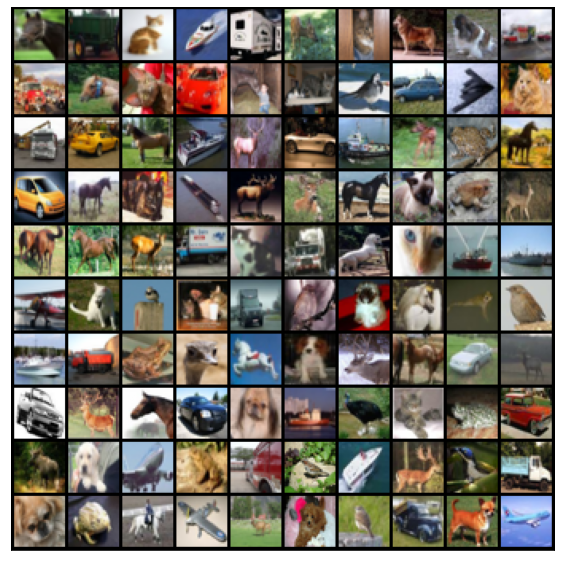

In [30]:
show_batch(train_dl)

# Convolutional Neural Network

In [31]:
import torch.nn as nn
import torch.nn.functional as F

In [33]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [34]:
for images, labels in train_dl:
    print(f'image.shape: {images.shape}')
    out = simple_model(images)
    print(f'out.shape: {out.shape}')
    break

image.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 8, 16, 16])


In [37]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 16 x 16

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 8 x 8

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 4 x 4

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 2 x 2

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 1 x 1

    nn.Flatten(), # output: bs x 16
    nn.Linear(16, 10) # output: bs x 10
)

In [38]:
for images, labels in train_dl:
    print(f'images.shape: {images.shape}')
    out = model(images)
    print(f'out.shape: {out.shape}')
    print(f'out[0]: {out[0]}')
    break

images.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 10])
out[0]: tensor([ 0.0845, -0.1791,  0.2448, -0.1115, -0.0876,  0.0238,  0.0693, -0.1866,
        -0.0684, -0.1508], grad_fn=<SelectBackward0>)


bird
airplane
Label: airplane (0)


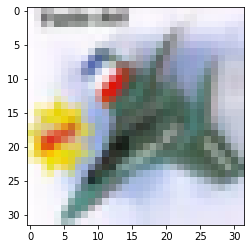

In [50]:
probs = (F.softmax(out[0], dim=0))
# torch.sum(probs), probs
print(dataset.classes[torch.argmax(probs, dim=0)])
print(dataset.classes[labels[0]])
show_example(images[0], labels[0])

In [51]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to choosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [52]:
device = get_default_device()
device

device(type='cuda')

In [53]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=16, out_features=10, bias=True)
)

In [54]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Generate Predictions
    preds = model(xb)
    # Calculate Loss 
    loss = loss_func(preds, yb)

    if opt is not None:
        # Compute Graditent 
        loss.backward()
        # Update parameters
        opt.step()
        # Reset Gradient
        opt.zero_grad()

    metric_result = None
    if metric is not None:
        # Compute the ,etric
        metric_result = metric(preds, yb)

    return loss.item(), len(xb), metric_result

In [55]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb, yb in valid_dl]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset 
        total = np.sum(nums)
        # Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric acros batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric 

In [64]:
from tqdm import tqdm

def fit(epochs, model, loss_fn, train_dl, valid_dl, opt_fn=None, lr=0.001, metric=None, ):
    train_losses, val_losses, metrics = [], [], []

    # Instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)

    for epoch in tqdm(range(epochs)):
        # Traning
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evalution
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        # Record te loss & metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        metrics.append(val_metric)

        # Print Progress
        if metric is None:
            print(f'Epoch [{epoch + 1}/{epochs}], tain_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}')
        else:
            print(f'Epoch [{epoch + 1}/{epochs}], tain_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_{metric.__name__}: {val_metric:.4f}')
    return train_losses, val_losses, metrics

In [58]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [59]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, valid_dl, metric=accuracy)
print(f'Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

Loss: 2.3110, Accuracy: 0.0985


In [60]:
num_epochs = 10
opt_fn = torch.optim.Adam
lr = 0.005

In [65]:
history = fit(
    num_epochs,
    model,
    F.cross_entropy,
    train_dl,
    valid_dl,
    opt_fn,
    lr,
    accuracy
)

train_losses, val_losses, val_metrices = history

 10%|█         | 1/10 [02:27<22:04, 147.19s/it]

Epoch [1/10], tain_loss: 1.6181, val_loss: 1.5800, val_accuracy: 0.4200


 20%|██        | 2/10 [02:48<09:45, 73.13s/it] 

Epoch [2/10], tain_loss: 1.5350, val_loss: 1.4536, val_accuracy: 0.4623


 30%|███       | 3/10 [03:09<05:45, 49.39s/it]

Epoch [3/10], tain_loss: 1.1155, val_loss: 1.3470, val_accuracy: 0.5154


 40%|████      | 4/10 [03:31<03:50, 38.43s/it]

Epoch [4/10], tain_loss: 1.3110, val_loss: 1.3147, val_accuracy: 0.5248


 50%|█████     | 5/10 [03:52<02:41, 32.27s/it]

Epoch [5/10], tain_loss: 1.3078, val_loss: 1.3542, val_accuracy: 0.5164


 60%|██████    | 6/10 [04:13<01:54, 28.58s/it]

Epoch [6/10], tain_loss: 1.1618, val_loss: 1.3064, val_accuracy: 0.5314


 70%|███████   | 7/10 [04:35<01:18, 26.21s/it]

Epoch [7/10], tain_loss: 1.3211, val_loss: 1.2657, val_accuracy: 0.5415


 80%|████████  | 8/10 [04:56<00:49, 24.68s/it]

Epoch [8/10], tain_loss: 1.0143, val_loss: 1.2180, val_accuracy: 0.5631


 90%|█████████ | 9/10 [05:18<00:23, 23.61s/it]

Epoch [9/10], tain_loss: 1.3043, val_loss: 1.2279, val_accuracy: 0.5588


100%|██████████| 10/10 [05:39<00:00, 33.91s/it]

Epoch [10/10], tain_loss: 1.2933, val_loss: 1.2197, val_accuracy: 0.5598


In [66]:
def plot_metric(metric_values):
    """Plot metric values in a line graph"""
    plt.plot(metric_values, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs No. of epochs')

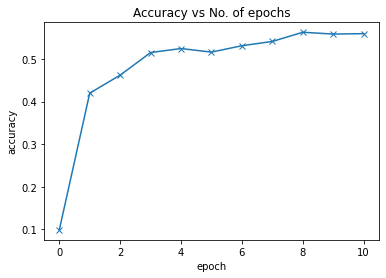

In [67]:
plot_metric([val_acc] + val_metrices)

In [68]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, '-x')
    plt.plot(val_losses, '-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Traning', 'Validation'])
    plt.title('Loss vs No. of epochs')

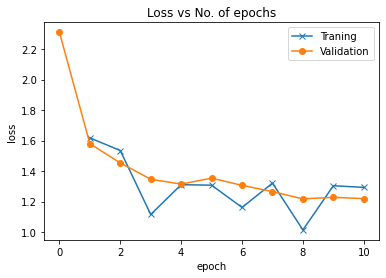

In [69]:
plot_losses([None] + train_losses, [val_loss] + val_losses)

In [70]:
test_dataset = ImageFolder(data_dir + '/test', transform=ToTensor())

In [71]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get prediction from model
    yb = model(xb.to(device))
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane, Predicted: airplane


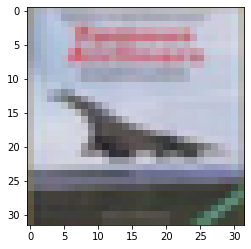

In [72]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print(f'Label: {dataset.classes[label]}, Predicted: {predict_image(img, model)}')

Label: automobile, Predicted: automobile


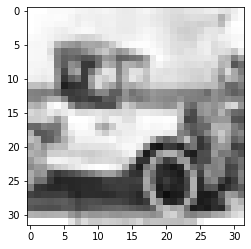

In [73]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print(f'Label: {dataset.classes[label]}, Predicted: {predict_image(img, model)}')

Label: frog, Predicted: frog


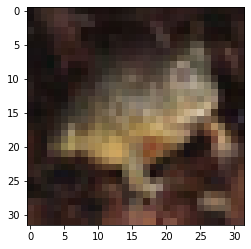

In [74]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print(f'Label: {dataset.classes[label]}, Predicted: {predict_image(img, model)}')

In [77]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)

test_loss, _, test_acc = evaluate(
    model, F.cross_entropy, test_loader, metric=accuracy
)
print(f'Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')

Loss: 1.2034, Accuracy: 0.5632
